# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# use this seed for random_state values
seed = 1

In [2]:
# make sure we're using sklearn 0.16
import sklearn
assert(sklearn.__version__.startswith('0.16'))

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

This is a classification problem, because we want to determine which students need intervention, so will assign each student to one of two classes - "intervene" or "don't intervene". Regression problems involve predicting a continuous value, e.g. price of a house. 

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [3]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import metrics

import time # use time.clock() - more accurate than time.time()

In [4]:
# allow inline plots
%matplotlib inline

# set default figure size
mpl.rcParams['figure.figsize'] = (13,5)

In [5]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

# show some of the data
student_data.sample(5)

Student data read successfully!


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
345,GP,F,18,U,GT3,T,3,2,other,services,...,yes,yes,5,4,3,2,3,1,7,yes
168,GP,F,16,U,GT3,T,2,2,other,other,...,yes,no,5,1,5,1,1,4,0,no
85,GP,F,15,U,GT3,T,4,4,services,services,...,yes,yes,4,4,4,2,3,5,6,no
22,GP,M,16,U,LE3,T,4,2,teacher,other,...,yes,no,4,5,1,1,3,5,2,yes
110,GP,M,15,U,LE3,A,4,4,teacher,teacher,...,yes,no,5,5,3,1,1,4,6,yes


### Examine correlations

In [6]:
def plotCorrelationMatrix(df):
    "plot correlation matrix of a pandas dataframe to a grid"
    # adapted from http://nbviewer.jupyter.org/gist/joelotz/5427209
    corr = df.corr() # get correlation matrix
    names = corr.columns
    plt.figure(figsize=(3,3))
    ax = plt.axes()
    ax.set_yticks(np.arange(corr.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(corr.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top() 
    ax.set_xticklabels(names,minor=False)
    ax.set_yticklabels(names,minor=False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.xticks(rotation=90)
    ax.grid(False)
    plt.pcolor(corr,cmap=mpl.cm.Greys);

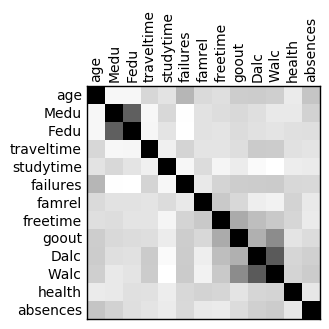

In [7]:
plotCorrelationMatrix(student_data)

In [8]:
# this shows how correlated some of the features are,
# which is supposed to be a problem for naive bayes.

# e.g. mothers and fathers education are correlated, 
# and studytime and alcohol consumption are inversely correlated, etc

### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [9]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns) - 1

# TODO: Calculate passing students
n_passed = len(student_data[student_data['passed']=='yes'])

# TODO: Calculate failing students
n_failed = len(student_data[student_data['passed']=='no'])

# TODO: Calculate graduation rate
grad_rate = float(n_passed) / n_students * 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [10]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_raw and y_raw, respectively)
X_raw = student_data[feature_cols]
y_raw = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
X_raw.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,4
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,4


### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, and has more than 2 values, convert to dummy variables
        if col_data.dtype == object:
            unique_values = col_data.unique()
            if len(unique_values)>2:
                # if more than 2 values, convert column to dummy variable columns
                col_data = pd.get_dummies(col_data, prefix = col)
            else:
                # if just one or two values, convert to 0 or 1 using LabelEncoder
                # see http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
                le.fit(col_data)
                col_data = pd.Series(le.transform(col_data), name=col_data.name)
        
        # Collect the revised columns
        output = output.join(col_data)
        
    return output

In [12]:
# process features and labels
X_all = preprocess_features(X_raw)
y_all = y_raw.replace(['yes','no'],[1, 0]) # convert yes/no to 1/0 so can get average f1 scores

# this works but splits out binary category features (aside from yes/no features), 
# which are better left as one feature.
# from https://discussions.udacity.com/t/preprocess-feature-columns/42404
#X_all = X_raw.apply(lambda x: x.replace(['yes', 'no'], [1, 0]) ,1)
#X_all = pd.get_dummies(X_raw)

# did this so could plot full correlation matrix but didn't show 
# any interesting correlations with 'passed' column.
#student_data2 = preprocess_features(student_data)
#X_all = student_data2.ix[:,:-1]
#y_all = student_data2.ix[:,-1:]

**Note:** I changed the above function so the binary features remained a single feature, e.g. school, instead of making two dummy columns. 

In [13]:
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (43 total features):
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [14]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train # 395-300=95

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    train_size = num_train, 
                                                    test_size = num_test, 
                                                    random_state = seed)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


In [15]:
# define training set sizes
training_set_sizes = [100,200,300]

# get training sets
X_training_sets = [X_train[:size] for size in training_set_sizes]
y_training_sets = [y_train[:size] for size in training_set_sizes]

In [16]:
# standardize the features -
# this subtracts the mean and divides by the standard deviation for each column.
# most learning algorithms apparently do better with standardized values.

# save this for later, or include in a Pipeline

#from sklearn.preprocessing import StandardScaler

#stdsc = StandardScaler()
#stdsc.fit(X_train)
#X_train_std = stdsc.transform(X_train)
#X_test_std = stdsc.transform(X_test)

## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

Some algorithms that might be appropriate for this problem include **Naive Bayes**, **Logistic Regression**, and **Support Vector Machines**. 

It's hard to come across good guidance on which algorithm to use when - on Quora and elsewhere there is sometimes contradictory advice - though there have been some studies done comparing their performance - e.g. see [0], in which Random Forests come out on top. 

[0] Manuel Fernandez-Delgado, Eva Cernadas, Senn Barro, Dinani Amorim, "Do we Need Hundreds of Classifiers to Solve Real World Classification Problems?", Journal of Machine Learning Research, 15(Oct):3133-3181, 2014. http://www.jmlr.org/papers/v15/delgado14a.html  

**Naive Bayes (NB)**

Naive Bayes is often used in text classification, e.g. spam detection [1].

Naive Bayes is a simple method and can be quite fast for training and predicting compared to more complex methods [2] - it also doesn't need as much data as other classifiers and is less prone to overfitting [3]. It performs well when features are independent of each other, but in some cases is still able to work well with collinearity, e.g. text classification, and is able to handle many features, e.g. thousands as in text classification. It scales well to huge datasets (millions of instances) [4], and is also able to fit quadratic piece-wise decision boundaries [5]. It has a closed form solution so doesn't require iteration to solve. 

Its weaknesses are in the independence requirement - it can perform poorly when there is collinearity between the features - highly correlated features are voted twice in the model and can lead to over-inflated importance [6]. 

It would be a good algorithm to try for this problem because it doesn't require much data, which is an issue in this case, and needs little in the way of computational resources. 

[1] Zhang, Haiyi, and Di Li. "Naive Bayes text classifier." Granular Computing, 2007. GRC 2007. IEEE International Conference on. IEEE, 2007. http://ieeexplore.ieee.org/document/4403192/  
[2] http://scikit-learn.org/stable/modules/naive_bayes.html  
[3] http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/  
[4] https://www.quora.com/What-are-the-typical-use-cases-for-different-machine-learning-algorithms/answer/Yuval-Feinstein?srid=Huzq  
[5] https://www.quora.com/What-is-the-decision-boundary-for-Naive-Bayes/answer/Sebastian-Raschka-1?srid=Huzq  
[6] https://www.analyticsvidhya.com/blog/2015/09/naive-bayes-explained/  

**Logistic Regression**

Logistic Regression is widely used in the health and medical fields, e.g. in assessing different cardiac arrest interventions [1].

It has the advantage that it is easy to see how much the different features contribute to the outcome, and does not require its input features to be scaled [2]. It's also relatively fast to train and to predict, and can perform well with a small amount of observations [3]. It uses gradient descent to find a solution. 

It only finds a single linear decision boundary though, so might not perform well if the decision boundary is irregular. [4]

Logistic Regression would be a good algorithm to try for this problem because its computational resource needs are modest, and it would also give the probability a student might pass - if educational resources are limited the teachers could focus more on the ones more likely to pass. 

[1] Terence D. Valenzuela, Denise J. Roe, Shan Cretin, Daniel W. Spaite and Mary P. Larsen, "Estimating Effectiveness of Cardiac Arrest Interventions: A Logistic Regression Survival Model". Circulation. November 18, 1997, Volume 96, Issue 10. http://circ.ahajournals.org/content/96/10/3308.short  
[2] http://www.dataschool.io/guide-to-logistic-regression/  
[3] http://nbviewer.jupyter.org/github/justmarkham/DAT8/blob/master/notebooks/12_logistic_regression.ipynb  
[4] https://florianhartl.com/logistic-regression-geometric-intuition.html  

**Support Vector Machine (SVM)**

Support Vector Machines are used in many different fields, for instance in the oil and gas industry to predict where oil might be found [1].

SVMs are good at handling high dimensional data, and are able to find linear or nonlinear decision boundaries. They use a subset of the training points in the decision function so are memory efficient [2].

They are slow to train relative to other algorithms, though - they are more than quadratic in the number of sample points - so don't scale well to very large datasets [3].

An SVM would be a good candidate for this problem because the dataset is small, hence the computing resources wouldn't be too heavy, and a nonlinear decision boundary could be found to separate the classes, so it might be more accurate than logistic regression. 

[1] Yuri Ccoicca, "Applications of Support Vector Machines in the Exploratory Phase of Petroleum and Natural Gas: a Survey", International Journal of Engineering and Technology, 2 (2) (2013) 113-125. https://www.researchgate.net/publication/243190076  
[2] http://scikit-learn.org/stable/modules/svm.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC  

**Baseline**

The three models will also be compared against a baseline model which just outputs the most likely label, i.e. it predicts that every student will pass. 

## Implementation: Model Performance Metrics

With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store 
your results.

In [17]:
# import classifiers
from sklearn.dummy          import DummyClassifier
from sklearn.naive_bayes    import GaussianNB
from sklearn.linear_model   import LogisticRegression
from sklearn.svm            import SVC

# create classifiers
classifiers = [
    ['Baseline',               DummyClassifier(strategy='most_frequent')], # eg assume all students will pass
    ['Gaussian Naive Bayes',   GaussianNB()], # no random_state
    ['Logistic Regression',    LogisticRegression(random_state=seed)],
    ['SVM',                    SVC(random_state=seed,kernel='rbf')],
]

In [18]:
# define some helper functions

def train_classifier(clf, features, labels):
    "Train the classifier with features and labels, return time spent"
    start = time.clock()
    clf.fit(features, labels)
    time_spent = time.clock() - start
    return time_spent

def predict_labels(clf, features, labels_actual, average='binary'):
    "Predict labels for given features, compare with actual labels and return f1 score and time spent"
    start = time.clock()
    labels_predict = clf.predict(features)
    time_spent = time.clock() - start
    #f1 = metrics.f1_score(labels_actual, labels_predict, average=average) # v0.18
    pos_label = 1 if average=='binary' else None # need this for v0.16
    f1 = metrics.f1_score(labels_actual, labels_predict, average=average, pos_label=pos_label)

    #print metrics.confusion_matrix(labels_actual, labels_predict)
    #print metrics.classification_report(labels_actual, labels_predict)
        
    return f1, time_spent

**Note:** The dataset is unbalanced (67% passing) so will use **StratifiedShuffleSplit** below, which shuffles the data and picks subsets to retain the same proportion of passing instances.

Also, since the dataset is so small there's lots of variance in the outcomes - changing the random_state can result in significant changes, so will do cross-fold validation instead of just one test-train split, and average the results. 

In [19]:
# train and test each classifier with different training sets, and store results in a list.
#from sklearn.model_selection import StratifiedShuffleSplit # v0.18
from sklearn.cross_validation import StratifiedShuffleSplit # v0.16

num_trains = [50,100,150,200,250,300] # training set size
num_test   = 95 # testing set size
num_trials = 10 # number of times to shuffle data and run each classifier

columns = ['Classifier','Training Set Size','Training Time (s)','Prediction Time (test) (s)',
           'F1 Score (train)', 'F1 Score (test)']
rows = []
for classifier_name, clf in classifiers:
    for num_train in num_trains:
        
        # each classifier should get the same sequence of random states,
        # so they train on the same subsets
        random_state = (seed+1) * num_train
        #sss = StratifiedShuffleSplit(n_splits=num_trials, train_size=num_train, test_size=num_test, 
        #                             random_state=random_state) # v0.18
        sss = StratifiedShuffleSplit(y_all, n_iter=num_trials, train_size=num_train, test_size=num_test, 
                                     random_state=random_state) # v0.16

        # shuffle the data, then split it into trial and test groups, keeping
        # the number of positive and negative labels proportional to the original group. 
        #for train_index, test_index in sss.split(X_all, y_all): # v0.18
        for train_index, test_index in sss: # v0.16
            X_train_subset, X_test_subset = X_all.values[train_index,:], X_all.values[test_index,:]
            y_train_subset, y_test_subset = y_all.values[train_index], y_all.values[test_index]

            # train classifier
            training_time = train_classifier(clf, X_train_subset, y_train_subset)

            # predict labels
            f1_train, prediction_time_train = predict_labels(clf, X_train_subset, y_train_subset)
            f1_test,  prediction_time_test  = predict_labels(clf, X_test_subset, y_test_subset)

            # add row of data to results
            num_train = len(X_train_subset)
            row = [classifier_name, num_train, training_time, prediction_time_test, f1_train, f1_test]
            rows.append(row)
            
# create pandas table with results
results = pd.DataFrame(rows, columns=columns)

### Tabular Results

In [20]:
# each classifier and training set size has 10 rows of results - 
# can group them and show the average
results_grouped = results.groupby(['Classifier','Training Set Size']).mean()
results_grouped

Training Time (s)  \
Classifier           Training Set Size                      
Baseline             50                          0.000083   
                     100                         0.000072   
                     150                         0.000061   
                     200                         0.000054   
                     250                         0.000052   
                     300                         0.000067   
Gaussian Naive Bayes 50                          0.000394   
                     100                         0.000498   
                     150                         0.000420   
                     200                         0.000368   
                     250                         0.000420   
                     300                         0.000633   
Logistic Regression  50                          0.000757   
                     100                         0.001316   
                     150                         0.001782   
                     200                         0.002440   
                     250                         0.002447   
                     300                         0.003046   
SVM                  50                          0.000437   
                     100                         0.001032   
                     150                         0.002015   
                     200                         0.004048   
                     250                         0.005103   
                     300                         0.006852   

                                        Prediction Time (test) (s)  \
Classifier           Training Set Size                               
Baseline             50                                   0.000072   
                     100                                  0.000057   
                     150                                  0.000052   
                     200                                  0.000047   
                     250                                  0.000045   
                     300                                  0.000062   
Gaussian Naive Bayes 50                                   0.000148   
                     100                                  0.000181   
                     150                                  0.000141   
                     200                                  0.000140   
                     250                                  0.000164   
                     300                                  0.000204   
Logistic Regression  50                                   0.000084   
                     100                                  0.000079   
                     150                                  0.000095   
                     200                                  0.000067   
                     250                                  0.000064   
                     300                                  0.000065   
SVM                  50                                   0.000398   
                     100                                  0.000718   
                     150                                  0.000944   
                     200                                  0.001368   
                     250                                  0.001497   
                     300                                  0.001718   

                                        F1 Score (train)  F1 Score (test)  
Classifier           Training Set Size                                     
Baseline             50                         0.809524         0.805031  
                     100                        0.802395         0.805031  
                     150                        0.804781         0.805031  
                     200                        0.802395         0.805031  
                     250                        0.803828         0.805031  
                     300                        0.802395         0.805031  
Gaussian Naive Bayes 50 

### Learning Curves

In [21]:
# show learning curves for the different classifiers
def plotLearningCurves(results):
    "show learning curves for the different classifiers"
    results_grouped = results.groupby(['Classifier','Training Set Size']).mean()
    clfnames = results_grouped.index.levels[0].values
    num_trains = results_grouped.index.levels[1].values
    iplot = 1
    plt.figure(figsize=(7,5))
    for clfname in clfnames:
        clfdata = results_grouped.ix[clfname]
        xs = num_trains
        f1_train = clfdata['F1 Score (train)']
        f1_test = clfdata['F1 Score (test)']
        plt.subplot(2,2,iplot)
        #plt.figure(figsize=(2,2))
        plt.title(clfname, weight='bold')
        plt.plot(xs, f1_train, 'o-')
        plt.plot(xs, f1_test, 'o-')
        plt.ylim(0.5,1.0)
        plt.xlabel('Training Set Size')
        plt.ylabel('F1 Score')
        iplot += 1
    plt.tight_layout()
    print 'Blue = Training Score, Green = Test Score'

Blue = Training Score, Green = Test Score


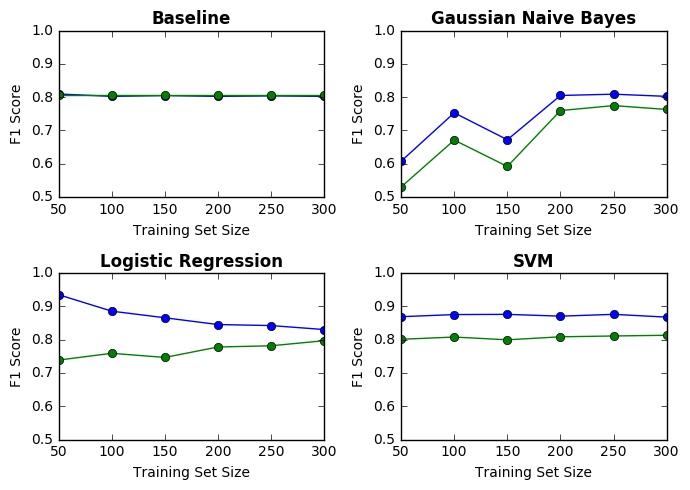

In [22]:
plotLearningCurves(results)

In [23]:
# q. why the odd shape for gnb training curve? shouldn't it have a high score at first? 

# depending on the random state used, these might look slightly different - 
# but typically they seem to have already gotten as good as they will get, 
# with a bit of a gap between the training and test curves, indicating a 
# slight degree of overfitting. 

### Average results

In [24]:
# show averages for each classifier for the max training set size, sorted by f1 test score
results_avg = results[results['Training Set Size']==300].groupby('Classifier').mean()
#results_avg.sort_values(by='F1 Score (test)', ascending=False) # newer version
results_avg.sort('F1 Score (test)', ascending=False)

,Training Set Size,Training Time (s),Prediction Time (test) (s),F1 Score (train),F1 Score (test)
Classifier,,,,,
SVM,300,0.006852,0.001718,0.867702,0.813223
Baseline,300,0.000067,0.000062,0.802395,0.805031
Logistic Regression,300,0.003046,0.000065,0.830400,0.796915
Gaussian Naive Bayes,300,0.000633,0.000204,0.802427,0.763054


In [25]:
# note that depending on the random state, the baseline classifier does 
# as good as or better than the other classifiers! (i.e. just by assuming everyone will pass)
# so maybe F1 isn't the best measure to use - let's look at some others...

In [26]:
# save result for end
#untuned_f1_train = results_avg.ix['Logistic Regression']['F1 Score (train)']

## More metrics

In [27]:
# try some other metrics for the different classifiers
columns = ['Classifier','Accuracy','Precision','Recall','FN','FP','F1 Train','F1','F1 Weighted','MCC']
rows = []
num_trains = [300] # just use the largest training set
num_test = 95
num_trials = 10
for classifier_name, clf in classifiers:
    for num_train in num_trains:
        random_state = (seed+1) * num_train # each classifier will get the same sequence of random states
        # v0.18
        #sss = StratifiedShuffleSplit(n_splits=num_trials, train_size=num_train, test_size=num_test, random_state=random_state)
        #for train_index, test_index in sss.split(X_all, y_all):
        # v0.16
        sss = StratifiedShuffleSplit(y_all, n_iter=num_trials, train_size=num_train, test_size=num_test, random_state=random_state)
        for train_index, test_index in sss:
            X_train_subset, X_test_subset = X_all.values[train_index,:], X_all.values[test_index,:]
            y_train_subset, y_test_subset = y_all.values[train_index], y_all.values[test_index]

            # train classifier and predict labels
            clf.fit(X_train_subset, y_train_subset)
            labels_predict = clf.predict(X_test_subset)
            labels_actual = y_test_subset

            # get metrics
            accuracy    = metrics.accuracy_score(labels_actual, labels_predict)
            precision   = metrics.precision_score(labels_actual, labels_predict)
            recall      = metrics.recall_score(labels_actual, labels_predict)
            f1_train    = metrics.f1_score(y_train_subset, clf.predict(X_train_subset)) # get f1 score on training data
            f1          = metrics.f1_score(labels_actual, labels_predict)
            f1_weighted = metrics.f1_score(labels_actual, labels_predict, average='weighted', pos_label=None) # v0.16 needs the pos_label=None
            mcc         = metrics.matthews_corrcoef(labels_actual, labels_predict)
            cm          = metrics.confusion_matrix(labels_actual, labels_predict)
            tn, fp, fn, tp = cm.ravel()

            # add to table
            row = [classifier_name, accuracy, precision, recall, fn, fp, f1_train, f1, f1_weighted, mcc]
            rows.append(row)

# make pandas table
results2 = pd.DataFrame(rows, columns=columns)

c:\anaconda\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
# show metrics
metric = 'MCC'
print 'Classifiers sorted by '+metric
results_grouped = results2.groupby('Classifier').mean()
#results_grouped.sort_values(by=metric, ascending=False) # new pandas version
results_grouped.sort(metric, ascending=False)

Classifiers sorted by MCC


,Accuracy,Precision,Recall,FN,FP,F1 Train,F1,F1 Weighted,MCC
Classifier,,,,,,,,,
Logistic Regression,0.702105,0.736678,0.868750,8.4,19.9,0.830400,0.796915,0.679860,0.265179
SVM,0.703158,0.706020,0.959375,2.6,25.6,0.867702,0.813223,0.636739,0.225441
Gaussian Naive Bayes,0.667368,0.733123,0.796875,13.0,18.6,0.802427,0.763054,0.657025,0.209734
Baseline,0.673684,0.673684,1.000000,0.0,31.0,0.802395,0.805031,0.542337,0.000000


Note that the Baseline classifier is now at the bottom where it should be, so maybe MCC or F1 weighted is a better way of measuring the performance of the classifiers?

**F1** by itself measures how accurate it is with the positive results, while 

**F1 weighted** gives a weighted average of both positive and negative labels.

**MCC** is **Matthews' Correlation Coefficient** - it includes all four numbers of the confusion matrix, so might be a better measure of all-around performance (0.0 indicates random guessing, which is appropriate for the Baseline classifier).

In [29]:
# save results for end
final_columns = list(columns)
final_columns[0] = 'Model' 
final_rows = []
row = ['Untuned']
row.extend(list(results_grouped.ix['Logistic Regression']))
final_rows.append(row)
final_table = pd.DataFrame(final_rows, columns = final_columns)

### Confusion Matrices

In [30]:
# let's look at some of the actual confusion matrices also
cms = {}
for clfname, clf in classifiers:
    print clfname
    # note: we just trained these classifiers in the previous step
    labels_predict = clf.predict(X_test_subset)
    labels_actual = y_test_subset
    cm = metrics.confusion_matrix(labels_actual, labels_predict)
    print cm
    cms[clfname] = cm
untuned_cm = cms['Logistic Regression'] # save for end

Baseline
[[ 0 31]
 [ 0 64]]
Gaussian Naive Bayes
[[13 18]
 [16 48]]
Logistic Regression
[[11 20]
 [10 54]]
SVM
[[ 6 25]
 [ 3 61]]


In [31]:
# so what do these mean? 
# they're different distributions of the 95 test students. 

# note that the Baseline classifier is very biased to the right - ie it assumes everyone will pass,
# and that the SVM is biased in a similar way. GNB and LR are more balanced. 

# what should we be more concerned about, false positives or false negatives? 
# a false positive would mean we thought they would pass, but they failed. 
# a false negative would mean we thought they would fail, but they passed. 

# so the false positives seem more costly - would let someone slip through the cracks. 
# otoh, a false negative would mean we spent extra resources where they weren't needed.

# another advantage of logistic regression is that you can change the threshold
# between the passing and failing prediction, which just defaults to 0.5. 
# this would let you adjust the false positive and false negative rates. 

## Feature contributions

In [32]:
# so which features contribute the most to the pass/fail outcome? 

# get the logistic regression classifier
assert classifiers[2][0]=='Logistic Regression'
clf = classifiers[2][1]

# get list of features and weights
columns_all = list(X_all.columns)
weights = pd.DataFrame(zip(columns_all, clf.coef_[0]), columns=['Feature','Weight'])
#weights = weights.sort_values(by='Weight',ascending=False) # v0.18
weights = weights.sort('Weight',ascending=False) # v.016

# keep track of interesting features
cols = []
cols.extend(list(weights.head(10)['Feature']))
cols.extend(list(weights.tail(10)['Feature']))
cols.append('Probability')

# show most positive correlations
weights.head(10)

,Feature,Weight
9,Mjob_health,0.539242
21,reason_reputation,0.535532
36,famrel,0.516630
0,school,0.506024
17,Fjob_teacher,0.466119
15,Fjob_other,0.435533
4,famsize,0.406526
22,guardian_father,0.394784
3,address,0.341428
23,guardian_mother,0.309096


In [33]:
# higher = wanting to continue on to college - makes sense
# Walc = weekend alcohol - positively correlated with passing?
# paid = ?
# Medu, Mjob_at_home

In [34]:
# show most negative correlations
#weights.tail(10).sort_values(by='Weight')
weights.tail(10).sort('Weight')

,Feature,Weight
28,schoolsup,-0.861017
29,famsup,-0.665447
27,failures,-0.621074
38,goout,-0.566909
35,romantic,-0.384097
18,reason_course,-0.311441
32,nursery,-0.310862
12,Mjob_teacher,-0.289411
13,Fjob_at_home,-0.234134
10,Mjob_other,-0.185960


In [35]:
# failures = previous failures
# schoolsup = getting extra support
# Mjob_teacher = mother is a teacher?
# goout = go out on weekend
# Fjob_at_home = father unemployed

## Sorting the students

In [36]:
# let's look at the students, sorting by probability of passing

probs = X_all.copy()
pcol = clf.predict_proba(X_all)[:,1]
probs['Probability'] = pcol
#probs = probs.sort_values(by='Probability', ascending=False)
probs = probs.sort('Probability', ascending=False)

In [37]:
# most likely to pass
probs[cols].head()

,Mjob_health,reason_reputation,famrel,school,Fjob_teacher,Fjob_other,famsize,guardian_father,address,guardian_mother,...,Fjob_at_home,Mjob_teacher,nursery,reason_course,romantic,goout,failures,famsup,schoolsup,Probability
393,0,0,4,1,0,1,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0.981065
30,1,0,5,0,0,0,0,0,1,1,...,0,0,0,0,0,2,0,1,0,0.977346
20,0,1,4,0,0,1,0,0,1,1,...,0,1,1,0,0,1,0,0,0,0.973293
236,0,0,4,0,0,1,1,1,1,0,...,0,0,0,0,1,2,0,0,0,0.970402
5,0,1,5,0,0,1,1,0,1,1,...,0,0,1,0,0,2,0,1,0,0.966883


In [38]:
# note that none have failed, and they don't go out very much

In [39]:
# most likely to fail
#probs[cols].tail().sort_values(by='Probability')
probs[cols].tail().sort('Probability')

,Mjob_health,reason_reputation,famrel,school,Fjob_teacher,Fjob_other,famsize,guardian_father,address,guardian_mother,...,Fjob_at_home,Mjob_teacher,nursery,reason_course,romantic,goout,failures,famsup,schoolsup,Probability
150,0,0,2,0,0,1,1,0,1,1,...,0,0,1,1,1,5,3,0,0,0.044397
153,0,0,4,0,0,0,0,0,1,1,...,1,0,1,0,1,4,3,1,0,0.051426
270,0,0,4,0,0,0,0,0,1,0,...,0,0,1,0,0,5,2,1,0,0.063538
206,0,0,2,0,0,1,0,0,1,1,...,0,0,1,1,0,3,3,1,0,0.077207
127,0,0,3,0,0,1,0,0,1,0,...,0,0,0,1,0,2,3,1,0,0.077725


In [40]:
# note the high number of previous failures, and they spend more time out

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

Based on the problem requirements and the experiments performed, **Logistic Regression** would be a good algorithm to use for this problem.

Logistic Regression ranked highest in terms of the scoring metrics used (MCC and F1 weighted), and the computing resources it needs are relatively low. It has the added benefit of returning the likelihood of each student passing, which would allow the schools to choose which students to focus on more carefully. The results are also more easily interpretable in terms of which features contribute the most to student performance, so could give clues as to how best to intervene with borderline students. 

Logistic Regression took 4 times as long to train as Gaussian Naive Bayes, but SVM took 13 times as long. It was slightly faster than Gaussian Naive Bayes at predicting outcomes though, and both were about 13x faster than the SVM. Computing power is cheap compared to teaching resources though, so having a better performing algorithm would presumably be worth the added cost (assuming that computing costs were extremely high for some reason).

**Additional Notes**

I wound up using **Matthews Correlation Coefficient (MCC)** to evaluate the classifiers, because the classes are unbalanced in this dataset (i.e. there are more students passing than failing), and using Accuracy or F1 score for just the positive cases could give misleading results. For example, the Baseline classifier of just assuming all students would pass outperformed several classifiers in additional testing when evaluated by the F1 score. 

Another better score than F1 is **F1 weighted**, which averages the F1 score for each class, instead of just testing the positive class. 

But the Matthews Correlation Coefficient takes all four values of the confusion matrix into account, so is a more balanced measure. http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

From scikit-learn - 

> The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. 

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html


Also posted here - https://discussions.udacity.com/t/using-matthews-correlation-coefficient-instead-of-f1/196357

### Question 4 - Model in Layman's Terms

*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

The program works by predicting the probability of each student passing, then identifying those students whose chances are less than 50% as ones who might fail. It must first be trained on existing data - it looks at all the variables collected about past students and whether they passed or failed, and builds a model than can predict the outcome for future students. 

Once the model is built you can reuse it as needed - you simply feed in the same variables for the new students and it will output the probability of them passing. You could then sort the students by the odds of their passing and choose which ones you want to focus extra resources on, in order to reach a 95% graduation rate. You could update it with new data every year or just continue to use it as is. 

### Implementation: Model Tuning

Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [41]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV

see   
http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html  
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  


In [42]:
# TODO: Create the parameters list you wish to tune

# logistic regression parameters
# C             the inverse of the regularization strength, 
#               so larger values could lead to more complex models and overfitting
# class_weight  balanced = splits are balanced to the proportion of positive/negative labels
# penalty       l1 = can ignore irrelevant features and save on computation, 
#                    ie can shrink some coefficients to zero, performing feature selection
#               l2 = default - shrinks all coefficients but eliminates none
#               see https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization

parameters = [    
  {'solver':       ['liblinear'],            # default is liblinear
   'random_state': [seed],                   # default is None
   'C':            [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], # default is 1
   'class_weight': [None,'auto'],            # default is None
   'penalty':      ['l1','l2'],              # default is l2
  },    
]

In [61]:
# TODO: Make a scoring function using 'make_scorer' 

scorer = metrics.make_scorer(metrics.f1_score)
#scorer = metrics.make_scorer(metrics.f1_score, average='weighted', pos_label=None) # v0.16 needs pos_label=None
#scorer = metrics.make_scorer(metrics.matthews_corrcoef) # doesn't seem to work - gives same results as f1

scorer_desc = scorer._score_func.__name__ + str(scorer._kwargs) # eg 'f1_score'
print 'Scorer:',scorer_desc

Scorer: f1_score{}


**Reviewer suggestion:** Can use StratifiedShuffleSplit here - pass to GridSearchCV as the cv parameter

In [70]:
# TODO: Initialize the classifier
clf = LogisticRegression(random_state=seed)

# get 10 stratified training and test sets
sss = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.24, random_state=seed)

# TODO: Perform grid search on the classifier optimizing against our scorer.
# by default cv=3 folds
grid = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=sss)

# can also pass string for scoring fn
# see http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#grid = GridSearchCV(estimator=clf, param_grid=parameters, scoring='accuracy', cv=sss)
#grid = GridSearchCV(estimator=clf, param_grid=parameters, scoring='f1', cv=sss)
#grid = GridSearchCV(estimator=clf, param_grid=parameters, scoring='f1_weighted', cv=sss)
#grid.scoring

In [63]:
# TODO: Fit the grid search object to the training data and find the optimal parameters
grid.fit(X_train, y_train)

# Get the estimator
clf = grid.best_estimator_

In [64]:
# print the best parameters and score
print 'Classifier parameter space:',parameters
print '\nBest parameters:',grid.best_params_
print '\nBest score:',grid.best_score_
print '\nClassifier:',clf

Classifier parameter space: [{'class_weight': [None, 'auto'], 'penalty': ['l1', 'l2'], 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], 'random_state': [1], 'solver': ['liblinear']}]

Best parameters: {'penalty': 'l1', 'C': 0.1, 'random_state': 1, 'solver': 'liblinear', 'class_weight': None}

Best score: 0.80710855794

Classifier: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0)


In [65]:
# make predictions on test set
y_predict = clf.predict(X_test)

# get accuracy, precision, recall
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict)
recall = metrics.recall_score(y_test, y_predict)

# get f1 scores
f1_train, _ = predict_labels(clf, X_train, y_train)
f1_test, _  = predict_labels(clf, X_test, y_test)
f1_test_weighted, _  = predict_labels(clf, X_test, y_test, 'weighted')

# get mcc score
mcc  = metrics.matthews_corrcoef(y_test, y_predict)

In [66]:
# get confusion matrix
tuned_cm = metrics.confusion_matrix(y_test, y_predict)
tn, fp, fn, tp = tuned_cm.ravel()

print 'Untuned\n',untuned_cm
print '\nTuned\n',tuned_cm

Untuned
[[11 20]
 [10 54]]

Tuned
[[ 9 19]
 [ 2 65]]


In [67]:
# add tuned results to final table
# note: final_columns = ['Model','Accuracy','Precision','Recall','FN','FP','F1 Train','F1','F1 Weighted','MCC']
row = ['Tuned',accuracy,precision,recall,fn,fp,f1_train,f1_test,f1_test_weighted,mcc]
# any nicer way?
# see http://stackoverflow.com/questions/26309962/appending-a-list-or-series-to-a-pandas-dataframe-as-a-row
fr = list(final_rows)
fr.append(row)
final_table = pd.DataFrame(fr, columns = final_columns)

In [68]:
print "Tuned model has a training F1 score of {:.4f}.".format(f1_train)
print "Tuned model has a testing F1 score of {:.4f}.".format(f1_test)

Tuned model has a training F1 score of 0.8128.
Tuned model has a testing F1 score of 0.8609.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

In [69]:
print 'Model optimized against',scorer_desc
final_table

Model optimized against f1_score{}


,Model,Accuracy,Precision,Recall,FN,FP,F1 Train,F1,F1 Weighted,MCC
0,Untuned,0.702105,0.736678,0.868750,8.4,19.9,0.830400,0.796915,0.679860,0.265179
1,Tuned,0.778947,0.773810,0.970149,2.0,19.0,0.812766,0.860927,0.743213,0.415465


**Answer: **

The table above shows the **untuned** values in the first row and **tuned** values in the second row. 

The table shows the values optimized against the **F1** score, which improves from 0.80 to 0.86 (the amount varies depending on the random state) - F1 Weighted and MCC improve also. 

## Conclusion

Logistic Regression gives a lot of information about the dataset and seems to make fairly good predictions about the student outcomes - better than the other two classifiers looked at - SVM and Gaussian Naive Bayes. 

There is much more that could be done with this dataset - feature selection, analyzing precision and recall, determining ROC, AUC, confidence intervals, comparing the different classifiers in more depth, etc. These could also be tied into a cost-benefit analysis of different options, including the cost of extra educational resources, cost of interventions (e.g. encouraging college attendance), long-term cost of a student failing, etc. This could also help identify the best way to get to the graduation rate of 95%. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.